# labs_bmi_bp_data_preprocessing.ipynb

**Primary Analyst:** Patrick Wu

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

# Set seed
np.random.seed(10011)

## Helper functions

In [2]:
# create function looking at top X number of labs
def top_labs(labs_df,num_labs=10):
    
    """function takes in lab in dataframe format and outputs 
    
        :param labs_df = lab dataframe with columns = {'RUID','Lab_name','Lab_date','Lab_value'}
        :param num_labs = top X of desired top labs to output from function, default = top 10
        
        :return = 
            top_num_labs: pandas dataframe with columns {'Lab_name','counts'} that contains only labs from top number of desired labs
            top_pt_labs: pandas dataframe with columns {'RUID', 'Lab_name', 'Lab_date','Lab_value'} that contains only labs from top number of desired labs
    """
    # preprocess lab dataframe to get sorted labs
    top_labs = pd.DataFrame(labs_df[['Lab_name']].groupby(['Lab_name']).size()).reset_index()
    top_labs.columns = ['Lab_name','counts']
    top_labs1 = top_labs.sort_values(by='counts',ascending=False)
    
    # get dataframe with columns = {'Lab_name', 'counts'}
    top_num_labs = top_labs1.iloc[0:int(num_labs),:]
    
    # create dataframe with only labs matching top labs
    top_pt_labs = labs_df[labs_df['Lab_name'].isin(top_num_labs['Lab_name'])]
    
    return top_num_labs, top_pt_labs

In [3]:
# write function to clean labs, to remove non-numeric values, etc.

def cleanLabs(labsdf):
    
    # sort labs dataframe to identify non-numeric values
    cleanlabs_df = labsdf.sort_values(by='lab_value',ascending=False)
    
    # convert non-numeric values to 'NaN'
    cleanlabs_df['lab_value'] = pd.to_numeric(cleanlabs_df['lab_value'],errors='coerce')
    
    # remove rows with NaN for Lab_value
    cleanlabs_df = cleanlabs_df[~cleanlabs_df['lab_value'].isna()]
    
    # return cleaned up labs dataframe
    return cleanlabs_df

In [4]:
# write function to clean labs, to remove non-numeric values, etc.
# note that this differs from the cleanLabs() function, as rows with NaN are NOT removed

def cleanLabs1(labsdf):
    
    # sort labs dataframe to identify non-numeric values
    cleanlabs_df = labsdf.sort_values(by='lab_value',ascending=False)
    
    # convert non-numeric values to 'NaN'
    cleanlabs_df['lab_value'] = pd.to_numeric(cleanlabs_df['lab_value'],errors='coerce')
    
    # return cleaned up labs dataframe
    return cleanlabs_df

In [5]:
# write function that returns merged table for labs with base_table
def stat_values_labs(labs_df, base_table):
    
    # merge cleaned up labs df with match 'ruid' and 'hospital_day' with base table
    labs_merged = pd.merge(labs_df, base_table, how='right', right_on=['ruid','hospital_day'], left_on=['ruid','lab_date'])
    
    # return merged df
    return labs_merged

In [6]:
def outlier_detection(lab_dataframe, lab_name):
    
    lab_df1 = lab_dataframe[lab_dataframe['lab_name']==lab_name]
    
    _ = plt.hist(lab_df1['lab_value'])
    
    lab_99 = np.nanpercentile(lab_df1['lab_value'], 99, interpolation='midpoint')
    lab_1 = np.nanpercentile(lab_df1['lab_value'], 1, interpolation='midpoint')
    
    print("99% percentile for ",lab_name,": ")
    
    return lab_99, lab_1

In [7]:
dir = '../data/'

## Aim #1: process labs to merge with base_table that has rows organized by 'ruid-visit_id' pairs

In [8]:
# import labs
df_LAB = pd.read_csv(dir+'FONNESBECK_LAB_20151202.csv',sep=',',engine='python',quoting=3,dtype={'RUID': str})
df_LAB.head()

,RUID,Lab_name,Lab_date,Lab_value
0,50135262,%SAT,04/13/2008,17
1,50135262,ABO,02/08/2007,A
2,50135262,ABO,02/24/2008,a
3,50135262,AN-GAP,02/08/2007,9
4,50135262,AN-GAP,02/11/2011,8


In [9]:
# top 20 labs
top_num_labs, top_pt_labs = top_labs(df_LAB,20)

In [10]:
top_num_labs

,Lab_name,counts
1762,GluBed,252113
2218,K,238492
1154,Creat,233493
2609,Na,230471
2776,PCV,229964
592,BUN,226556
1765,Gluc,226554
926,CO2,226256
1070,Cl,226059
2920,Plt-Ct,215131


based on these results, will use all labs from `GluBed` to `Ca`, since there's a big drop-off between `Ca` and `RDWSD`

In [11]:
# get all labs from GluBed to Ca, i.e. filter RDWSD
top_num_labs1, top_pt_labs1 = top_labs(df_LAB,19)

In [12]:
top_pt_labs1['Lab_name'].value_counts()

GluBed    252113
K         238492
Creat     233493
Na        230471
PCV       229964
BUN       226556
Gluc      226554
CO2       226256
Cl        226059
Plt-Ct    215131
WBC       213850
Hgb       213328
RBC       210475
MCHC      209793
MCH       209463
MCV       207226
RDW       207028
AN-GAP    205919
Ca        198994
Name: Lab_name, dtype: int64

In [13]:
top_pt_labs1.columns = ['ruid','lab_name','lab_date','lab_value']
top_pt_labs1.head()

,ruid,lab_name,lab_date,lab_value
3,50135262,AN-GAP,02/08/2007,9
4,50135262,AN-GAP,02/11/2011,8
5,50135262,AN-GAP,02/12/2011,6
6,50135262,AN-GAP,02/13/2007,9
7,50135262,AN-GAP,02/13/2011,8


In [14]:
# clean labs, i.e. lab_value  to NaN if not numeric
top_pt_labs2 = cleanLabs1(top_pt_labs1)
top_pt_labs2.head()

,ruid,lab_name,lab_date,lab_value
5503436,53732927,Plt-Ct,07/25/2013,NaN
6301228,53733765,Na,10/23/1999,NaN
2683342,53730260,CO2,02/10/2000,NaN
2684017,53730260,K,02/10/2000,NaN
2239788,53729811,Creat,05/26/2000,NaN


In [15]:
top_pt_labs2.isna().sum()

ruid             0
lab_name         0
lab_date         0
lab_value    18659
dtype: int64

In [16]:
top_pt_labs2.shape

(4181165, 4)

In [17]:
# read in base table that I will use for merging
base_table = pd.read_pickle(dir+'adt_cms_final.pkl')

In [18]:
base_table.head()

,ruid,visit_id,admit_date,discharge_date,hospital_day,stay_length,n_transfers,readmit_time,readmit_30d
0,50135262,0,2007-02-08,2007-02-12,2007-02-08,4 days,2,172 days,0
1,50135262,0,2007-02-08,2007-02-12,2007-02-09,4 days,2,172 days,0
2,50135262,0,2007-02-08,2007-02-12,2007-02-10,4 days,2,172 days,0
3,50135262,0,2007-02-08,2007-02-12,2007-02-11,4 days,2,172 days,0
4,50135262,0,2007-02-08,2007-02-12,2007-02-12,4 days,2,172 days,0


In [19]:
base_table = base_table[['ruid','visit_id','hospital_day']]
base_table.head()

,ruid,visit_id,hospital_day
0,50135262,0,2007-02-08
1,50135262,0,2007-02-09
2,50135262,0,2007-02-10
3,50135262,0,2007-02-11
4,50135262,0,2007-02-12


In [20]:
top_pt_labs3 = top_pt_labs2.copy()
top_pt_labs3['lab_date'] = pd.to_datetime(top_pt_labs3['lab_date'], infer_datetime_format=True)

In [21]:
labs_merged = stat_values_labs(top_pt_labs3, base_table)

In [22]:
labs_merged['lab_name'].value_counts()

GluBed    195640
K         105807
Creat     101488
Na         99744
Gluc       99521
PCV        98626
CO2        98172
Cl         97929
BUN        97509
AN-GAP     97319
Plt-Ct     94594
WBC        91173
RBC        90898
Hgb        90570
MCHC       90423
MCH        90151
RDW        89502
MCV        88022
Ca         83371
Name: lab_name, dtype: int64

## Aim #2: clean labs

1) convert outliers in GluBed to NaN 

99% percentile for  GluBed : 


/anaconda3/envs/bios8366/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/envs/bios8366/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(422.0, 54.0)

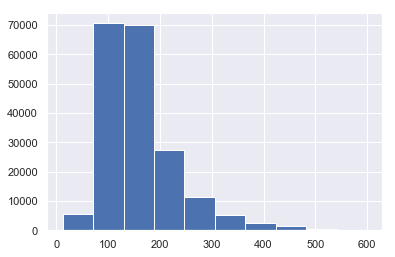

In [23]:
outlier_detection(labs_merged, 'GluBed')

so convert values <50 and >400 to NaN

In [24]:
# create initial pandas dataframe to which I will concat additional modified dataframes for the other labs

# get all GluBed records from labs_merged df
labs = labs_merged[labs_merged.lab_name=='GluBed']

In [25]:
labs.isna().sum()

ruid              0
lab_name          0
lab_date          0
lab_value       729
visit_id          0
hospital_day      0
dtype: int64

In [26]:
# convert GluBed values >400 to NaN
labs['lab_value'][labs['lab_value']>400] = np.nan

# convert GluBed values <60 to NaN
labs['lab_value'][labs['lab_value']<50] = np.nan

labs.isna().sum()

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/bios8366/lib/python3.6/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/anaconda3/envs/bios8366/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/envs/bi

ruid               0
lab_name           0
lab_date           0
lab_value       4787
visit_id           0
hospital_day       0
dtype: int64

In [27]:
labs.describe()

,lab_value,visit_id
count,190853.000000,195640.000000
mean,157.404227,4.268094
std,62.622005,6.172680
min,50.000000,0.000000
25%,114.000000,0.000000
50%,142.000000,2.000000
75%,186.000000,6.000000
max,400.000000,55.000000


2) convert outliers in `K` to NaN

99% percentile for  K : 


(6.0, 2.7)

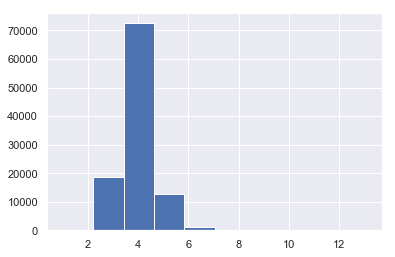

In [28]:
outlier_detection(labs_merged, 'K')

so convert `K` values >6.0 or <2.0 to NaN

In [29]:
labs_k = labs_merged[labs_merged.lab_name=='K']

In [30]:
labs_k.describe()

,lab_value,visit_id
count,105405.000000,105807.000000
mean,4.000900,5.303137
std,0.660934,8.928306
min,1.000000,0.000000
25%,3.600000,0.000000
50%,3.900000,2.000000
75%,4.300000,6.000000
max,13.100000,100.000000


for efficiency purposes, create new `outlier_conversion` function 

In [31]:
def outlier_conversion(df, labs, low_cutoff, high_cutoff):
    
    """
    This function takes in subset from labs_merged df and outputs converted df with upper and lower cut-offs converted to NaN
    
    Input
    :param df = labs dataframe subset
    :param labs = base labs table with outliers removed
    :param low_cutoff = lower boundary cut-off for transformation to NaN
    :param high_cutoff = upper boundary cut-off for transformation to NaN 
    
    Output
    :variable df_lab = same dataframe with selected lab_values transformed to NaN
    :variable labs = df_lab concatenated to base labs dataframe that has outliers removed
    """
    
    df_lab = df.copy()
    
    # convert lab values >high_cutoff to NaN
    df_lab['lab_value'][df_lab['lab_value']>high_cutoff] = np.nan

    # convert lab values <low_cutoff to NaN
    df_lab['lab_value'][df_lab['lab_value']<low_cutoff] = np.nan
    
    # concatenates to base lab dataframe
    labs = pd.concat([df_lab,labs])

    return df_lab, labs

In [32]:
labs_k, labs = outlier_conversion(labs_k,labs,2,6)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
labs_k.describe()

,lab_value,visit_id
count,104327.000000,105807.000000
mean,3.975162,5.303137
std,0.600100,8.928306
min,2.000000,0.000000
25%,3.600000,0.000000
50%,3.900000,2.000000
75%,4.300000,6.000000
max,6.000000,100.000000


In [34]:
labs.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
18,53732537,K,2015-04-25,3.9,5,2015-04-25
52,53728342,K,2014-05-26,NaN,9,2014-05-26
63,53728342,K,2014-05-26,4.2,9,2014-05-26
70,53728342,K,2014-05-26,3.5,9,2014-05-26
96,53735977,K,2014-03-15,3.4,3,2014-03-15


In [35]:
labs['lab_name'].unique()

array(['K', 'GluBed'], dtype=object)

3) convert outliers in `Creat` to NaN, normal values = 0.7-1.3

99% percentile for  Creat : 


(9.2, 0.38)

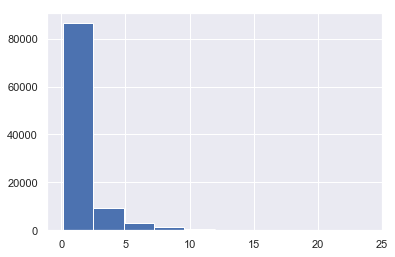

In [36]:
outlier_detection(labs_merged, 'Creat')

In [37]:
labs_creat = labs_merged[labs_merged.lab_name=='Creat']

In [38]:
labs_creat.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
16,53732537,Creat,2015-04-25,4.20,5,2015-04-25
51,53728342,Creat,2014-05-26,NaN,9,2014-05-26
64,53728342,Creat,2014-05-26,4.19,9,2014-05-26
84,53728342,Creat,2014-05-26,0.79,9,2014-05-26
107,53735977,Creat,2014-03-15,0.78,3,2014-03-15


In [39]:
labs_creat.describe()

,lab_value,visit_id
count,101149.000000,101488.000000
mean,1.593544,5.392460
std,1.720670,9.082819
min,0.100000,0.000000
25%,0.730000,0.000000
50%,1.000000,2.000000
75%,1.640000,7.000000
max,23.840000,100.000000


In [40]:
labs_creat, labs = outlier_conversion(labs_creat,labs,0.37,8)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [41]:
labs_creat.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
16,53732537,Creat,2015-04-25,4.20,5,2015-04-25
51,53728342,Creat,2014-05-26,NaN,9,2014-05-26
64,53728342,Creat,2014-05-26,4.19,9,2014-05-26
84,53728342,Creat,2014-05-26,0.79,9,2014-05-26
107,53735977,Creat,2014-03-15,0.78,3,2014-03-15


In [42]:
labs_creat.describe()

,lab_value,visit_id
count,98639.000000,101488.000000
mean,1.458610,5.392460
std,1.261744,9.082819
min,0.370000,0.000000
25%,0.730000,0.000000
50%,1.000000,2.000000
75%,1.600000,7.000000
max,8.000000,100.000000


In [43]:
labs_creat.isna().sum()

ruid               0
lab_name           0
lab_date           0
lab_value       2849
visit_id           0
hospital_day       0
dtype: int64

In [44]:
labs.lab_name.unique()

array(['Creat', 'K', 'GluBed'], dtype=object)

In [45]:
labs.shape

(402935, 6)

4) convert outliers in `Na` to NaN, normal values = 136-145

99% percentile for  Na : 


(150.0, 125.0)

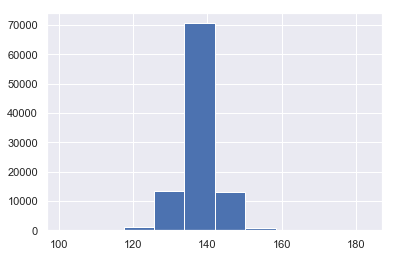

In [46]:
outlier_detection(labs_merged, 'Na')

In [47]:
labs_na = labs_merged[labs_merged.lab_name=='Na']

In [48]:
labs_na.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
29,53732537,Na,2015-04-25,130.0,5,2015-04-25
54,53728342,Na,2014-05-26,NaN,9,2014-05-26
77,53728342,Na,2014-05-26,146.0,9,2014-05-26
78,53728342,Na,2014-05-26,142.0,9,2014-05-26
102,53735977,Na,2014-03-15,138.0,3,2014-03-15


In [49]:
labs_na.describe()

,lab_value,visit_id
count,99111.000000,99744.000000
mean,137.564730,5.371712
std,4.583072,9.068976
min,101.000000,0.000000
25%,135.000000,0.000000
50%,138.000000,2.000000
75%,140.000000,6.000000
max,183.000000,100.000000


In [50]:
labs_na, labs = outlier_conversion(labs_na,labs,125,150)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
labs_na.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
29,53732537,Na,2015-04-25,130.0,5,2015-04-25
54,53728342,Na,2014-05-26,NaN,9,2014-05-26
77,53728342,Na,2014-05-26,146.0,9,2014-05-26
78,53728342,Na,2014-05-26,142.0,9,2014-05-26
102,53735977,Na,2014-03-15,138.0,3,2014-03-15


In [52]:
labs_na.describe()

,lab_value,visit_id
count,97304.000000,99744.000000
mean,137.557346,5.371712
std,3.940998,9.068976
min,125.000000,0.000000
25%,135.000000,0.000000
50%,138.000000,2.000000
75%,140.000000,6.000000
max,150.000000,100.000000


In [53]:
labs_na.isna().sum()

ruid               0
lab_name           0
lab_date           0
lab_value       2440
visit_id           0
hospital_day       0
dtype: int64

In [54]:
labs.lab_name.unique()

array(['Na', 'Creat', 'K', 'GluBed'], dtype=object)

In [55]:
labs.shape

(502679, 6)

5) convert outliers in `PCV` to NaN, normal values = 38.8-50 (Males), 34.9-44.5 (Females)

99% percentile for  PCV : 


(47.0, 19.0)

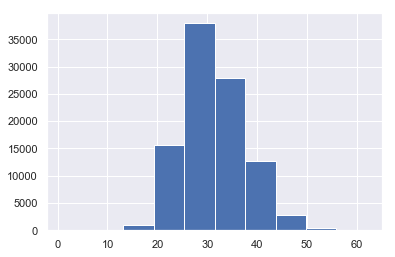

In [56]:
outlier_detection(labs_merged, 'PCV')

In [57]:
labs_pcv = labs_merged[labs_merged.lab_name=='PCV']

In [58]:
labs_pcv.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
0,53732537,PCV,2015-04-25,NaN,5,2015-04-25
21,53732537,PCV,2015-04-25,22.0,5,2015-04-25
40,53732537,PCV,2015-04-25,NaN,5,2015-04-25
46,53728342,PCV,2014-05-26,NaN,9,2014-05-26
61,53728342,PCV,2014-05-26,44.0,9,2014-05-26


In [59]:
labs_pcv['lab_value'].describe()

count    98397.000000
mean        31.230283
std          6.150949
min          1.000000
25%         27.000000
50%         31.000000
75%         35.000000
max         62.000000
Name: lab_value, dtype: float64

In [60]:
# note that since max normal range PCV for males is 50, will keep all upper values
labs_pcv, labs = outlier_conversion(labs_pcv,labs,19,65)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [61]:
labs_pcv.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
0,53732537,PCV,2015-04-25,NaN,5,2015-04-25
21,53732537,PCV,2015-04-25,22.0,5,2015-04-25
40,53732537,PCV,2015-04-25,NaN,5,2015-04-25
46,53728342,PCV,2014-05-26,NaN,9,2014-05-26
61,53728342,PCV,2014-05-26,44.0,9,2014-05-26


In [62]:
labs_pcv.describe()

,lab_value,visit_id
count,97664.000000,98626.000000
mean,31.352824,5.325786
std,5.994504,9.358813
min,19.000000,0.000000
25%,27.000000,0.000000
50%,31.000000,2.000000
75%,35.000000,6.000000
max,62.000000,100.000000


In [63]:
labs_pcv.isna().sum()

ruid              0
lab_name          0
lab_date          0
lab_value       962
visit_id          0
hospital_day      0
dtype: int64

In [64]:
labs.lab_name.unique()

array(['PCV', 'Na', 'Creat', 'K', 'GluBed'], dtype=object)

In [65]:
labs.shape

(601305, 6)

6) convert outliers in `BUN` to NaN, normal values = 6-20

99% percentile for  BUN : 


(111.0, 2.0)

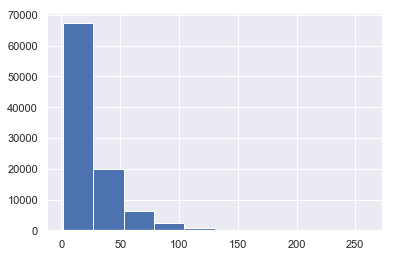

In [66]:
outlier_detection(labs_merged, 'BUN')

In [67]:
labs_bun = labs_merged[labs_merged.lab_name=='BUN']

In [68]:
labs_bun.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
15,53732537,BUN,2015-04-25,50.0,5,2015-04-25
106,53735977,BUN,2014-03-15,10.0,3,2014-03-15
127,53735233,BUN,2014-09-06,21.0,1,2014-09-06
129,53735233,BUN,2014-09-06,20.0,1,2014-09-06
133,53735233,BUN,2014-09-06,19.0,1,2014-09-06


In [69]:
labs_bun['lab_value'].describe()

count    97032.000000
mean        24.620630
std         22.558807
min          1.000000
25%         10.000000
50%         17.000000
75%         31.000000
max        260.000000
Name: lab_value, dtype: float64

In [70]:
labs_bun, labs = outlier_conversion(labs_bun,labs,2,100)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [71]:
labs_bun.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
15,53732537,BUN,2015-04-25,50.0,5,2015-04-25
106,53735977,BUN,2014-03-15,10.0,3,2014-03-15
127,53735233,BUN,2014-09-06,21.0,1,2014-09-06
129,53735233,BUN,2014-09-06,20.0,1,2014-09-06
133,53735233,BUN,2014-09-06,19.0,1,2014-09-06


In [72]:
labs_bun.describe()

,lab_value,visit_id
count,95210.000000,97509.000000
mean,23.201943,5.432883
std,18.821791,9.144858
min,2.000000,0.000000
25%,10.000000,0.000000
50%,17.000000,2.000000
75%,30.000000,7.000000
max,100.000000,100.000000


In [73]:
labs_bun.isna().sum()

ruid               0
lab_name           0
lab_date           0
lab_value       2299
visit_id           0
hospital_day       0
dtype: int64

In [74]:
labs.lab_name.unique()

array(['BUN', 'PCV', 'Na', 'Creat', 'K', 'GluBed'], dtype=object)

In [75]:
labs.shape

(698814, 6)

7) convert outliers in `Gluc` to NaN, normal values = 70-100

99% percentile for  Gluc : 


(404.0, 57.0)

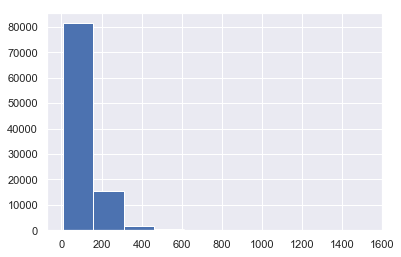

In [76]:
outlier_detection(labs_merged, 'Gluc')

In [77]:
labs_gluc = labs_merged[labs_merged.lab_name=='Gluc']

In [78]:
labs_gluc.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
33,53732537,Gluc,2015-04-25,110.0,5,2015-04-25
104,53735977,Gluc,2014-03-15,114.0,3,2014-03-15
124,53735233,Gluc,2014-09-06,235.0,1,2014-09-06
131,53735233,Gluc,2014-09-06,196.0,1,2014-09-06
132,53735233,Gluc,2014-09-06,194.0,1,2014-09-06


In [79]:
labs_gluc['lab_value'].describe()

count    99221.000000
mean       128.994437
std         68.272490
min          6.000000
25%         94.000000
50%        111.000000
75%        141.000000
max       1525.000000
Name: lab_value, dtype: float64

In [80]:
labs_gluc, labs = outlier_conversion(labs_gluc,labs,40,400)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [81]:
labs_gluc.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
33,53732537,Gluc,2015-04-25,110.0,5,2015-04-25
104,53735977,Gluc,2014-03-15,114.0,3,2014-03-15
124,53735233,Gluc,2014-09-06,235.0,1,2014-09-06
131,53735233,Gluc,2014-09-06,196.0,1,2014-09-06
132,53735233,Gluc,2014-09-06,194.0,1,2014-09-06


In [82]:
labs_gluc.describe()

,lab_value,visit_id
count,98027.000000,99521.000000
mean,124.755363,5.395153
std,49.987419,9.044776
min,40.000000,0.000000
25%,93.000000,0.000000
50%,111.000000,2.000000
75%,140.000000,7.000000
max,400.000000,100.000000


In [83]:
labs_gluc.isna().sum()

ruid               0
lab_name           0
lab_date           0
lab_value       1494
visit_id           0
hospital_day       0
dtype: int64

In [84]:
labs.lab_name.unique()

array(['Gluc', 'BUN', 'PCV', 'Na', 'Creat', 'K', 'GluBed'], dtype=object)

In [85]:
labs.shape

(798335, 6)

8) convert outliers in `CO2` to NaN, normal values = 23-29

99% percentile for  CO2 : 


(36.0, 14.0)

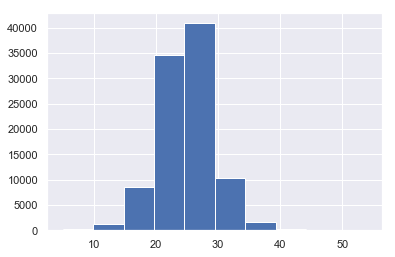

In [86]:
outlier_detection(labs_merged, 'CO2')

In [87]:
labs_co2 = labs_merged[labs_merged.lab_name=='CO2']

In [88]:
labs_co2.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
25,53732537,CO2,2015-04-25,17.0,5,2015-04-25
53,53728342,CO2,2014-05-26,NaN,9,2014-05-26
69,53728342,CO2,2014-05-26,30.0,9,2014-05-26
72,53728342,CO2,2014-05-26,22.0,9,2014-05-26
99,53735977,CO2,2014-03-15,24.0,3,2014-03-15


In [89]:
labs_co2['lab_value'].describe()

count    97866.000000
mean        24.857378
std          4.462933
min          5.000000
25%         22.000000
50%         25.000000
75%         28.000000
max         54.000000
Name: lab_value, dtype: float64

In [90]:
labs_co2, labs = outlier_conversion(labs_co2,labs,14,36)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [91]:
labs_co2.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
25,53732537,CO2,2015-04-25,17.0,5,2015-04-25
53,53728342,CO2,2014-05-26,NaN,9,2014-05-26
69,53728342,CO2,2014-05-26,30.0,9,2014-05-26
72,53728342,CO2,2014-05-26,22.0,9,2014-05-26
99,53735977,CO2,2014-03-15,24.0,3,2014-03-15


In [92]:
labs_co2.describe()

,lab_value,visit_id
count,95938.000000,98172.000000
mean,24.856330,5.418103
std,4.020049,9.103099
min,14.000000,0.000000
25%,22.000000,0.000000
50%,25.000000,2.000000
75%,27.000000,7.000000
max,36.000000,100.000000


In [93]:
labs_co2.isna().sum()

ruid               0
lab_name           0
lab_date           0
lab_value       2234
visit_id           0
hospital_day       0
dtype: int64

In [94]:
labs.lab_name.unique()

array(['CO2', 'Gluc', 'BUN', 'PCV', 'Na', 'Creat', 'K', 'GluBed'],
      dtype=object)

In [95]:
labs.shape

(896507, 6)

9) convert outliers in `Cl` to NaN, normal values = 96-106

99% percentile for  Cl : 


(119.0, 87.0)

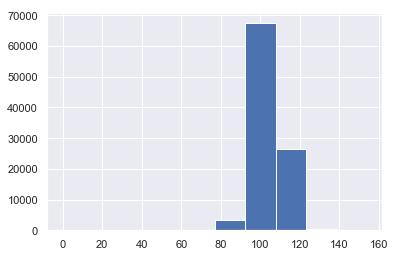

In [96]:
outlier_detection(labs_merged, 'Cl')

In [97]:
labs_cl = labs_merged[labs_merged.lab_name=='Cl']

In [98]:
labs_cl.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
34,53732537,Cl,2015-04-25,100.0,5,2015-04-25
105,53735977,Cl,2014-03-15,108.0,3,2014-03-15
145,53735233,Cl,2014-09-06,114.0,1,2014-09-06
146,53735233,Cl,2014-09-06,110.0,1,2014-09-06
147,53735233,Cl,2014-09-06,109.0,1,2014-09-06


In [99]:
labs_cl['lab_value'].describe()

count    97637.000000
mean       104.144474
std          6.236027
min          0.000000
25%        101.000000
50%        104.000000
75%        108.000000
max        154.000000
Name: lab_value, dtype: float64

In [100]:
labs_cl, labs = outlier_conversion(labs_cl,labs,87,119)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [101]:
labs_cl.lab_name.unique()

array(['Cl'], dtype=object)

In [102]:
labs_cl.describe()

,lab_value,visit_id
count,95902.000000,97929.000000
mean,104.124961,5.422092
std,5.613041,9.114513
min,87.000000,0.000000
25%,101.000000,0.000000
50%,104.000000,2.000000
75%,108.000000,7.000000
max,119.000000,100.000000


In [103]:
labs_cl.isna().sum()

ruid               0
lab_name           0
lab_date           0
lab_value       2027
visit_id           0
hospital_day       0
dtype: int64

In [104]:
labs.lab_name.unique()

array(['Cl', 'CO2', 'Gluc', 'BUN', 'PCV', 'Na', 'Creat', 'K', 'GluBed'],
      dtype=object)

In [105]:
labs.shape

(994436, 6)

10) convert outliers in `Plt-Ct` to NaN, normal values = 150-450

99% percentile for  Plt-Ct : 


(677.0, 13.0)

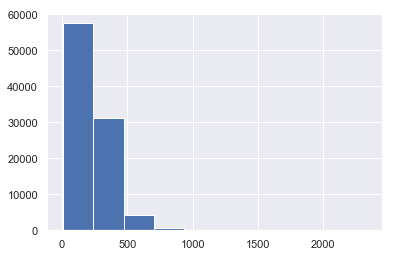

In [106]:
outlier_detection(labs_merged, 'Plt-Ct')

In [107]:
labs_plt = labs_merged[labs_merged.lab_name=='Plt-Ct']

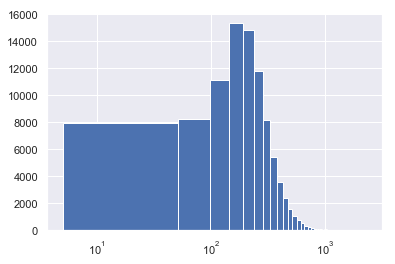

In [108]:
# want to take a look at log transformed histogram
fig, ax = plt.subplots()

n_bins=50

_=ax.hist(labs_plt.lab_value, bins=n_bins)

ax.set_xscale('log', basex=10)

In [109]:
labs_plt['lab_value'].describe()

count    93776.000000
mean       223.114187
std        141.654463
min          5.000000
25%        130.000000
50%        204.000000
75%        290.000000
max       2334.000000
Name: lab_value, dtype: float64

In [110]:
labs_plt, labs = outlier_conversion(labs_plt,labs,20,1000)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [111]:
labs_plt.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
1,53732537,Plt-Ct,2015-04-25,NaN,5,2015-04-25
9,53732537,Plt-Ct,2015-04-25,NaN,5,2015-04-25
19,53732537,Plt-Ct,2015-04-25,271.0,5,2015-04-25
45,53728342,Plt-Ct,2014-05-26,NaN,9,2014-05-26
59,53728342,Plt-Ct,2014-05-26,60.0,9,2014-05-26


In [112]:
labs_plt.describe()

,lab_value,visit_id
count,91157.000000,94594.000000
mean,227.300778,5.500888
std,133.521809,9.571813
min,20.000000,0.000000
25%,137.000000,0.000000
50%,208.000000,2.000000
75%,292.000000,7.000000
max,1000.000000,100.000000


In [113]:
labs_plt.isna().sum()

ruid               0
lab_name           0
lab_date           0
lab_value       3437
visit_id           0
hospital_day       0
dtype: int64

In [114]:
labs.lab_name.unique()

array(['Plt-Ct', 'Cl', 'CO2', 'Gluc', 'BUN', 'PCV', 'Na', 'Creat', 'K',
       'GluBed'], dtype=object)

In [115]:
labs.shape

(1089030, 6)

11) convert outliers in `WBC` to NaN, normal values = 3.5-10.5

99% percentile for  WBC : 


(31.6, 0.2)

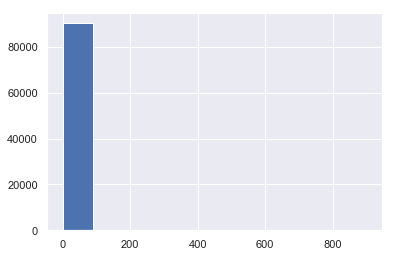

In [116]:
outlier_detection(labs_merged, 'WBC')

In [117]:
labs_wbc = labs_merged[labs_merged.lab_name=='WBC']

In [118]:
labs_wbc.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
3,53732537,WBC,2015-04-25,NaN,5,2015-04-25
32,53732537,WBC,2015-04-25,12.3,5,2015-04-25
36,53732537,WBC,2015-04-25,NaN,5,2015-04-25
42,53728342,WBC,2014-05-26,NaN,9,2014-05-26
60,53728342,WBC,2014-05-26,6.2,9,2014-05-26


In [119]:
labs_wbc['lab_value'].describe()

count    90303.000000
mean         9.553975
std          8.035340
min          0.100000
25%          5.600000
50%          8.400000
75%         12.000000
max        902.000000
Name: lab_value, dtype: float64

In [120]:
labs_wbc, labs = outlier_conversion(labs_wbc,labs,0.2,32)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [121]:
labs_wbc.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
3,53732537,WBC,2015-04-25,NaN,5,2015-04-25
32,53732537,WBC,2015-04-25,12.3,5,2015-04-25
36,53732537,WBC,2015-04-25,NaN,5,2015-04-25
42,53728342,WBC,2014-05-26,NaN,9,2014-05-26
60,53728342,WBC,2014-05-26,6.2,9,2014-05-26


In [122]:
labs_wbc.describe()

,lab_value,visit_id
count,88623.000000,91173.000000
mean,9.240726,5.540171
std,5.263929,9.615497
min,0.200000,0.000000
25%,5.700000,0.000000
50%,8.400000,2.000000
75%,11.900000,7.000000
max,32.000000,100.000000


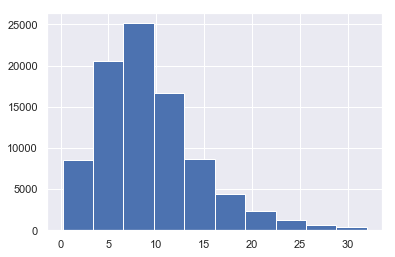

In [123]:
# want to see histogram of cleaned wbc data
fig, ax = plt.subplots()

_=ax.hist(labs_wbc.lab_value)

In [124]:
labs_wbc.isna().sum()

ruid               0
lab_name           0
lab_date           0
lab_value       2550
visit_id           0
hospital_day       0
dtype: int64

In [125]:
labs.lab_name.unique()

array(['WBC', 'Plt-Ct', 'Cl', 'CO2', 'Gluc', 'BUN', 'PCV', 'Na', 'Creat',
       'K', 'GluBed'], dtype=object)

In [126]:
labs.shape

(1180203, 6)

12) convert outliers in `Hgb` to NaN, normal values = 13.5-17.5 (males), 12.0-15.5 (females)

99% percentile for  Hgb : 


(15.9, 6.3)

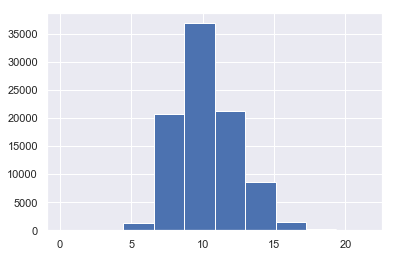

In [127]:
outlier_detection(labs_merged, 'Hgb')

In [128]:
labs_hgb = labs_merged[labs_merged.lab_name=='Hgb']

In [129]:
labs_hgb.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
6,53732537,Hgb,2015-04-25,NaN,5,2015-04-25
14,53732537,Hgb,2015-04-25,6.9,5,2015-04-25
37,53732537,Hgb,2015-04-25,NaN,5,2015-04-25
44,53728342,Hgb,2014-05-26,NaN,9,2014-05-26
57,53728342,Hgb,2014-05-26,7.1,9,2014-05-26


In [130]:
labs_hgb['lab_value'].describe()

count    90367.000000
mean        10.270862
std          2.089365
min          0.200000
25%          8.800000
50%         10.000000
75%         11.600000
max         21.500000
Name: lab_value, dtype: float64

In [131]:
# note that i won't convert larger values here since max is close to max normal range of 17.5 in males
labs_hgb, labs = outlier_conversion(labs_hgb,labs,5,25)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [132]:
labs_hgb.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
6,53732537,Hgb,2015-04-25,NaN,5,2015-04-25
14,53732537,Hgb,2015-04-25,6.9,5,2015-04-25
37,53732537,Hgb,2015-04-25,NaN,5,2015-04-25
44,53728342,Hgb,2014-05-26,NaN,9,2014-05-26
57,53728342,Hgb,2014-05-26,7.1,9,2014-05-26


In [133]:
labs_hgb.describe()

,lab_value,visit_id
count,90232.000000,90570.000000
mean,10.280059,5.534371
std,2.077098,9.615115
min,5.000000,0.000000
25%,8.800000,0.000000
50%,10.000000,2.000000
75%,11.600000,7.000000
max,21.500000,100.000000


In [134]:
labs_hgb.isna().sum()

ruid              0
lab_name          0
lab_date          0
lab_value       338
visit_id          0
hospital_day      0
dtype: int64

In [135]:
labs.lab_name.unique()

array(['Hgb', 'WBC', 'Plt-Ct', 'Cl', 'CO2', 'Gluc', 'BUN', 'PCV', 'Na',
       'Creat', 'K', 'GluBed'], dtype=object)

In [136]:
labs.shape

(1270773, 6)

13) convert outliers in `RBC` to NaN, normal values = 4.32-5.72 (males), 3.90-5.03 (females)

99% percentile for  RBC : 


(5.42, 2.1)

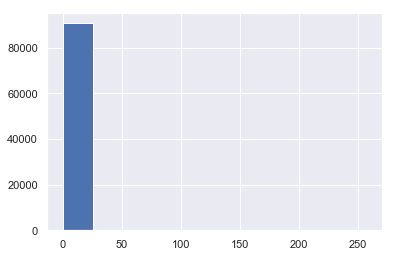

In [137]:
outlier_detection(labs_merged, 'RBC')

In [138]:
labs_rbc = labs_merged[labs_merged.lab_name=='RBC']

In [139]:
labs_rbc.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
2,53732537,RBC,2015-04-25,NaN,5,2015-04-25
22,53732537,RBC,2015-04-25,2.74,5,2015-04-25
38,53732537,RBC,2015-04-25,NaN,5,2015-04-25
49,53728342,RBC,2014-05-26,NaN,9,2014-05-26
62,53728342,RBC,2014-05-26,4.24,9,2014-05-26


In [140]:
labs_rbc['lab_value'].describe()

count    90685.000000
mean         3.543625
std          1.121429
min          0.140000
25%          3.010000
50%          3.470000
75%          4.020000
max        258.000000
Name: lab_value, dtype: float64

In [141]:
labs_rbc, labs = outlier_conversion(labs_rbc,labs,2,10)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [142]:
labs_rbc.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
2,53732537,RBC,2015-04-25,NaN,5,2015-04-25
22,53732537,RBC,2015-04-25,2.74,5,2015-04-25
38,53732537,RBC,2015-04-25,NaN,5,2015-04-25
49,53728342,RBC,2014-05-26,NaN,9,2014-05-26
62,53728342,RBC,2014-05-26,4.24,9,2014-05-26


In [143]:
labs_rbc.describe()

,lab_value,visit_id
count,90116.000000,90898.000000
mean,3.552078,5.530650
std,0.725544,9.611853
min,2.000000,0.000000
25%,3.020000,0.000000
50%,3.480000,2.000000
75%,4.030000,7.000000
max,9.590000,100.000000


In [144]:
labs_rbc.isna().sum()

ruid              0
lab_name          0
lab_date          0
lab_value       782
visit_id          0
hospital_day      0
dtype: int64

In [145]:
labs.lab_name.unique()

array(['RBC', 'Hgb', 'WBC', 'Plt-Ct', 'Cl', 'CO2', 'Gluc', 'BUN', 'PCV',
       'Na', 'Creat', 'K', 'GluBed'], dtype=object)

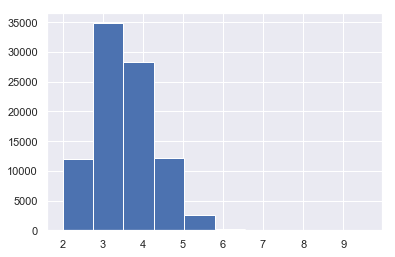

In [146]:
fig, ax = plt.subplots()
_=ax.hist(labs_rbc.lab_value)

In [147]:
labs.shape

(1361671, 6)

14) convert outliers in `MCHC` to NaN, normal values = 33-36

99% percentile for  MCHC : 


(36.2, 28.7)

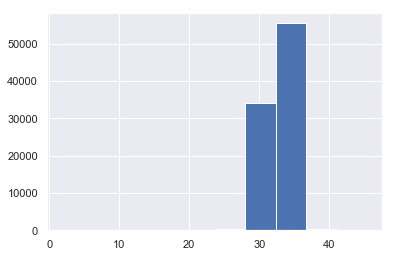

In [148]:
outlier_detection(labs_merged, 'MCHC')

In [149]:
labs_mchc = labs_merged[labs_merged.lab_name=='MCHC']

In [150]:
labs_mchc.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
8,53732537,MCHC,2015-04-25,NaN,5,2015-04-25
17,53732537,MCHC,2015-04-25,31.5,5,2015-04-25
39,53732537,MCHC,2015-04-25,NaN,5,2015-04-25
50,53728342,MCHC,2014-05-26,NaN,9,2014-05-26
67,53728342,MCHC,2014-05-26,33.3,9,2014-05-26


In [151]:
labs_mchc['lab_value'].describe()

count    90229.000000
mean        32.776071
std          1.598843
min          1.900000
25%         31.800000
50%         32.800000
75%         33.900000
max         45.400000
Name: lab_value, dtype: float64

In [152]:
labs_mchc, labs = outlier_conversion(labs_mchc,labs,28,40)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [153]:
labs_mchc.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
8,53732537,MCHC,2015-04-25,NaN,5,2015-04-25
17,53732537,MCHC,2015-04-25,31.5,5,2015-04-25
39,53732537,MCHC,2015-04-25,NaN,5,2015-04-25
50,53728342,MCHC,2014-05-26,NaN,9,2014-05-26
67,53728342,MCHC,2014-05-26,33.3,9,2014-05-26


In [154]:
labs_mchc.describe()

,lab_value,visit_id
count,89825.000000,90423.000000
mean,32.802021,5.536456
std,1.546169,9.619425
min,28.000000,0.000000
25%,31.800000,0.000000
50%,32.800000,2.000000
75%,33.900000,7.000000
max,40.000000,100.000000


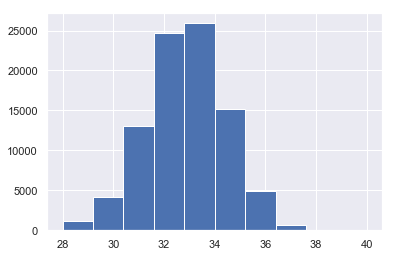

In [155]:
fig, ax = plt.subplots()
_=ax.hist(labs_mchc.lab_value)

In [156]:
labs_mchc.isna().sum()

ruid              0
lab_name          0
lab_date          0
lab_value       598
visit_id          0
hospital_day      0
dtype: int64

In [157]:
labs.lab_name.unique()

array(['MCHC', 'RBC', 'Hgb', 'WBC', 'Plt-Ct', 'Cl', 'CO2', 'Gluc', 'BUN',
       'PCV', 'Na', 'Creat', 'K', 'GluBed'], dtype=object)

In [158]:
labs.shape

(1452094, 6)

15) convert outliers in `MCH` to NaN, normal values = 27-33

99% percentile for  MCH : 


(35.7, 21.2)

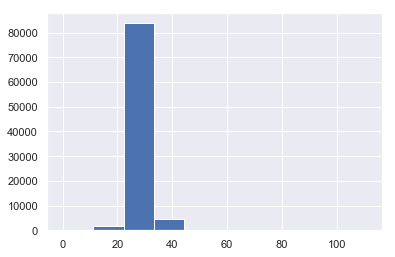

In [159]:
outlier_detection(labs_merged, 'MCH')

In [160]:
labs_mch = labs_merged[labs_merged.lab_name=='MCH']

In [161]:
labs_mch.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
7,53732537,MCH,2015-04-25,NaN,5,2015-04-25
20,53732537,MCH,2015-04-25,25.2,5,2015-04-25
35,53732537,MCH,2015-04-25,NaN,5,2015-04-25
47,53728342,MCH,2014-05-26,NaN,9,2014-05-26
66,53728342,MCH,2014-05-26,34.4,9,2014-05-26


In [162]:
labs_mch['lab_value'].describe()

count    89957.000000
mean        29.179418
std          2.809424
min          0.000000
25%         27.800000
50%         29.400000
75%         30.800000
max        111.100000
Name: lab_value, dtype: float64

In [163]:
labs_mch, labs = outlier_conversion(labs_mch,labs,21,36)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


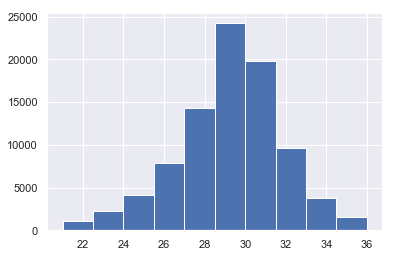

In [164]:
fig, ax = plt.subplots()
_=ax.hist(labs_mch.lab_value)

In [165]:
labs.lab_name.unique()

array(['MCH', 'MCHC', 'RBC', 'Hgb', 'WBC', 'Plt-Ct', 'Cl', 'CO2', 'Gluc',
       'BUN', 'PCV', 'Na', 'Creat', 'K', 'GluBed'], dtype=object)

In [166]:
labs.shape

(1542245, 6)

16) convert outliers in `MCV` to NaN, nl range = 80-96

99% percentile for  MCV : 


(107.0, 69.0)

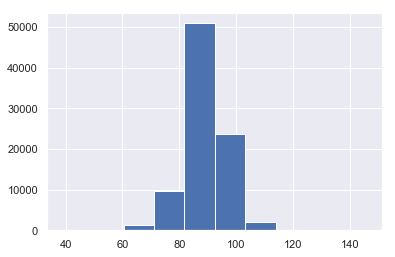

In [167]:
outlier_detection(labs_merged, 'MCV')

In [168]:
labs_mcv = labs_merged[labs_merged.lab_name=='MCV']

In [169]:
labs_mcv.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
5,53732537,MCV,2015-04-25,NaN,5,2015-04-25
12,53732537,MCV,2015-04-25,80.0,5,2015-04-25
41,53732537,MCV,2015-04-25,NaN,5,2015-04-25
43,53728342,MCV,2014-05-26,NaN,9,2014-05-26
55,53728342,MCV,2014-05-26,90.0,9,2014-05-26


In [170]:
labs_mcv['lab_value'].describe()

count    87830.000000
mean        89.063481
std          7.269603
min         39.000000
25%         85.000000
50%         89.000000
75%         93.000000
max        146.000000
Name: lab_value, dtype: float64

In [171]:
labs_mcv, labs = outlier_conversion(labs_mcv,labs,69,107)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


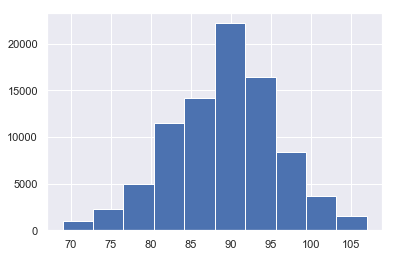

In [172]:
fig, ax = plt.subplots()
_=ax.hist(labs_mcv.lab_value)

In [173]:
labs.lab_name.unique()

array(['MCV', 'MCH', 'MCHC', 'RBC', 'Hgb', 'WBC', 'Plt-Ct', 'Cl', 'CO2',
       'Gluc', 'BUN', 'PCV', 'Na', 'Creat', 'K', 'GluBed'], dtype=object)

In [174]:
labs.shape

(1630267, 6)

17) convert outliers in `RDW` to NaN, normal values = 11.6-14.6 (if this is RDW-CV)

99% percentile for  RDW : 


(24.5, 12.2)

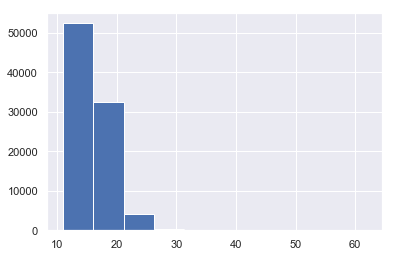

In [175]:
outlier_detection(labs_merged, 'RDW')

In [176]:
labs_rdw = labs_merged[labs_merged.lab_name=='RDW']

In [177]:
labs_rdw.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
4,53732537,RDW,2015-04-25,NaN,5,2015-04-25
10,53732537,RDW,2015-04-25,NaN,5,2015-04-25
26,53732537,RDW,2015-04-25,14.3,5,2015-04-25
48,53728342,RDW,2014-05-26,NaN,9,2014-05-26
79,53728342,RDW,2014-05-26,14.8,9,2014-05-26


In [178]:
labs_rdw['lab_value'].describe()

count    89287.000000
mean        16.038718
std          2.642581
min         10.900000
25%         14.100000
50%         15.500000
75%         17.400000
max         62.000000
Name: lab_value, dtype: float64

In [179]:
# note: going to keep outliers for lower-bound because its close to smaller number in range
labs_rdw, labs = outlier_conversion(labs_rdw,labs,5,24.5)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


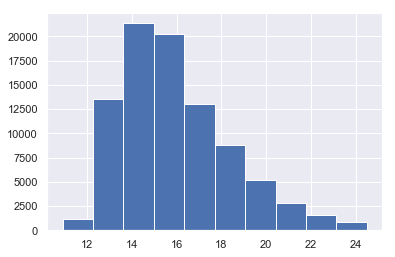

In [180]:
fig, ax = plt.subplots()
_=ax.hist(labs_rdw.lab_value)

In [181]:
labs.lab_name.unique()

array(['RDW', 'MCV', 'MCH', 'MCHC', 'RBC', 'Hgb', 'WBC', 'Plt-Ct', 'Cl',
       'CO2', 'Gluc', 'BUN', 'PCV', 'Na', 'Creat', 'K', 'GluBed'],
      dtype=object)

In [182]:
labs.shape

(1719769, 6)

18) convert outliers in `AN-GAP` to NaN, nl range = 4-12 (newer technique), 8-16 (older technique)

99% percentile for  AN-GAP : 


(19.0, 2.0)

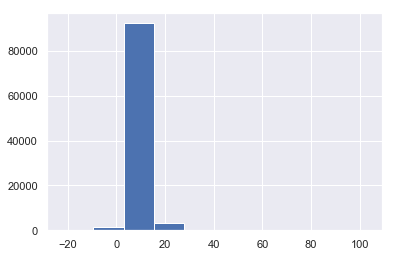

In [183]:
outlier_detection(labs_merged, 'AN-GAP')

In [184]:
labs_angap = labs_merged[labs_merged.lab_name=='AN-GAP']

In [185]:
labs_angap.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
30,53732537,AN-GAP,2015-04-25,13.0,5,2015-04-25
93,53735977,AN-GAP,2014-03-15,6.0,3,2014-03-15
111,53735233,AN-GAP,2014-09-06,8.0,1,2014-09-06
139,53735233,AN-GAP,2014-09-06,14.0,1,2014-09-06
144,53735233,AN-GAP,2014-09-06,12.0,1,2014-09-06


In [186]:
labs_angap['lab_value'].describe()

count    97287.00000
mean         8.53410
std          3.51002
min        -22.00000
25%          6.00000
50%          8.00000
75%         10.00000
max        103.00000
Name: lab_value, dtype: float64

In [187]:
labs_angap, labs = outlier_conversion(labs_angap,labs,2,19)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


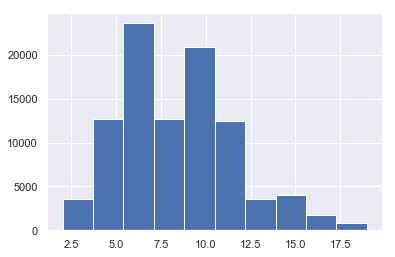

In [188]:
fig, ax = plt.subplots()
_=ax.hist(labs_angap.lab_value)

In [189]:
labs.lab_name.unique()

array(['AN-GAP', 'RDW', 'MCV', 'MCH', 'MCHC', 'RBC', 'Hgb', 'WBC',
       'Plt-Ct', 'Cl', 'CO2', 'Gluc', 'BUN', 'PCV', 'Na', 'Creat', 'K',
       'GluBed'], dtype=object)

In [190]:
labs.shape

(1817088, 6)

19) convert outliers in `Ca` to NaN, nl range = 8.5-10.2

99% percentile for  Ca : 


(10.4, 6.5)

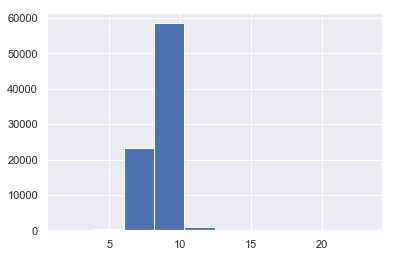

In [191]:
outlier_detection(labs_merged, 'Ca')

In [192]:
labs_ca = labs_merged[labs_merged.lab_name=='Ca']

In [193]:
labs_ca.head()

,ruid,lab_name,lab_date,lab_value,visit_id,hospital_day
11,53732537,Ca,2015-04-25,9.4,5,2015-04-25
88,53735977,Ca,2014-03-15,8.5,3,2014-03-15
155,53733675,Ca,2014-02-09,9.8,5,2014-02-09
184,53728759,Ca,2013-05-30,8.1,4,2013-05-30
223,53735479,Ca,2013-12-30,8.0,1,2013-12-30


In [194]:
labs_ca['lab_value'].describe()

count    83160.000000
mean         8.523585
std          0.786102
min          1.700000
25%          8.100000
50%          8.500000
75%          9.000000
max         23.200000
Name: lab_value, dtype: float64

In [195]:
labs_ca, labs = outlier_conversion(labs_ca,labs,6.5,15)

/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


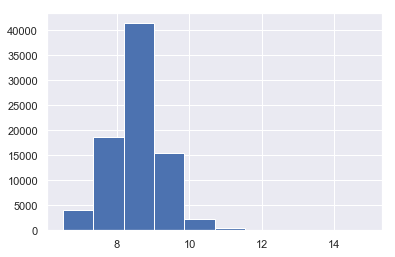

In [196]:
fig, ax = plt.subplots()
_=ax.hist(labs_ca.lab_value)

In [197]:
labs.lab_name.unique()

array(['Ca', 'AN-GAP', 'RDW', 'MCV', 'MCH', 'MCHC', 'RBC', 'Hgb', 'WBC',
       'Plt-Ct', 'Cl', 'CO2', 'Gluc', 'BUN', 'PCV', 'Na', 'Creat', 'K',
       'GluBed'], dtype=object)

In [198]:
labs.shape

(1900459, 6)

In [200]:
# export labs to csv
labs.to_csv(dir+'labs_cleaned.csv', index=False)